# Homework 5

# Part I

### 1. 

In order to proceed you need Microsoft Excel and file "https://www.dropbox.com/s/cows9cnxn0hwk4i/DailyFactors.csv?dl=1". 
(also in blackboard)

a) Start by importing the data, parsing the date appropriate, and setting it as the index

b) Create a new data set that contains only the risk-free rate and the excess return on the market (MKT-RF). Note that this data is already in excess return.

c) Using the pandas rolling method (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html), build a function that takes as parameter "ndays_rv", the number of days in a windown, and returns the moving-average variance estimator for that windown. For example, if you choose ndays_rv=22, the function should return a dataframe where you have days in the index and in the column you have the realize variance of the last 22 days. 

Note that this is different from what we did in class because we grouped stuff by month, so we converted the frequency of the data set to monthly. Here we are keeping it daily by the variance is still estimated using the last "ndays_rv" trading days.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display_html

# a) Start by importing the data, parsing the date appropriate, and setting it as the index
df = pd.read_csv("https://www.dropbox.com/s/cows9cnxn0hwk4i/DailyFactors.csv?dl=1", na_values = -99, index_col = 0)/100
df.index = pd.to_datetime(df.index, format = "%Y%m%d", errors = "ignore")
df.index.name = "Date"
df.head()

,Mkt-RF,SMB,HML,Mom,RMW,CMA,LTRev,STRev,Food,Mines,...,Machn,Cars,Trans,Utils,Rtail,Fi-99,Other,Bond10yr,Bond1yr,RF
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-01,0.0010,-0.0024,-0.0028,NaN,NaN,NaN,NaN,0.0047,0.0003,0.0030,...,-0.0012,-0.0015,0.0009,0.0061,-0.0001,0.0060,-0.0001,NaN,NaN,0.00009
1926-07-02,0.0045,-0.0031,-0.0007,NaN,NaN,NaN,NaN,0.0066,0.0011,0.0036,...,0.0038,0.0109,0.0005,0.0047,0.0001,-0.0002,0.0038,NaN,NaN,0.00009
1926-07-06,0.0017,0.0028,-0.0034,NaN,NaN,NaN,NaN,-0.0007,0.0005,-0.0019,...,0.0051,0.0088,-0.0016,0.0073,-0.0023,0.0008,0.0016,NaN,NaN,0.00009
1926-07-07,0.0009,-0.0061,0.0007,NaN,NaN,NaN,NaN,0.0057,0.0054,-0.0017,...,-0.0012,0.0004,0.0013,0.0017,-0.0060,-0.0018,0.0042,NaN,NaN,0.00009
1926-07-08,0.0021,-0.0036,0.0016,NaN,NaN,NaN,NaN,0.0002,0.0094,0.0034,...,0.0048,0.0001,0.0046,-0.0020,-0.0036,-0.0042,0.0049,NaN,NaN,0.00009


In [2]:
# b) Create a new data set that contains only the risk-free rate and the excess return on the market (MKT-RF). 
df_erf = df[["Mkt-RF", "RF"]]
df_erf.head()

,Mkt-RF,RF
Date,,
1926-07-01,0.0010,0.00009
1926-07-02,0.0045,0.00009
1926-07-06,0.0017,0.00009
1926-07-07,0.0009,0.00009
1926-07-08,0.0021,0.00009


In [3]:
# c) Using the pandas rolling method, build a function.
def varest(ndays_rv):
    return(df_erf.rolling(ndays_rv).var())

,Mkt-RF,RF
Date,,
2015-03-25,0.000064,1.020128e-22
2015-03-26,0.000064,1.020128e-22
2015-03-27,0.000064,1.020128e-22
2015-03-30,0.000072,1.020128e-22
2015-03-31,0.000074,1.020128e-22


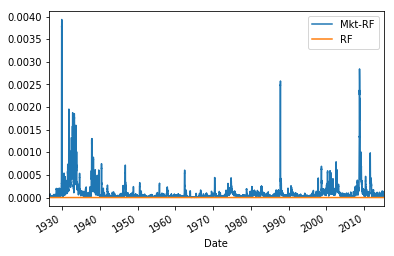

In [4]:
display(varest(22).tail())
varest(22).plot()

### 2. 

a) Extend the function to implement a volatility managed strategy that uses the Realized variance estimator of question 1 to construt weight $W=c/RV(ndays_rv)$, where I write ndays, because Your RV will depend of the ndays paramenter. Make the function to automatically set $c$ so that W-1<=5 99% of time in the sample. That is when you change ndays_rv, the function should re-estimate the datafram RV(ndays_rv), and automatically calculate c and construct the portfolio weight. TIP: use the quantile function for RV and set c so that 
$W=c/RV(ndays_rv).quantile(0.01)=5$

b) Now construct the trading strategy that using weights of three days ago W(t-3), buys W(t-3) of the excess return MKT-Rf and holds for "ndays_holding" trading days. To do that you need to start by compounding the daily returns to the ndays_holding trading horizon.

TIP: you need to follow the steps 
 
 1) Transform the market back into a return, by adding the risk-free rate. You can only compound returns, not excess returns
 
 2) use the .rolling method together with the .prod, to compound both the market and the risk-free returns
 
 3) Make sure to convert back and forth to gross and net returns as needed
 
 4) use as windown ndays_holding to compound the returns for ndays_holding days
 
 5) The rolling operator will compound returns looking back, so if the window is, say, 22 days, and the date in 1/31/2019 it will assign to january 31 the compounded return of havign invested in the asset 22 days ago.
 
 6) To get it lined up with our trading strategy we need to use the .shift method. Basically to simulate an strategy that buys 3 days after the end of the signal estimation windown and holds for ndays_holding, you need to lag the weight by 3+ndays_holding relative to the compounded return. There are lots of ways of doing this. 
 
 7) Here we want to keep the date line up with the exit date, so for example, in the end if I have that my strategy earned 10% in 1/31, then that is the return I got between ndays_holding before and 1/31. To do this we will lage the weight by 3 using .shift(-3) and lead the compounded return by ndays_holding, .shift(-ndays_holding)
 
 8) in the end you have $Data['RVMS']=Data.W.shift(3)* Data.MKT.shift(-'ndays holding')+(1-Data.W.shift(3))* Data.RF.shift(-'ndays holding')$, where the returns used here are the compounded returns 

c) You now have the return of your stragey, in fact because your data-set is daily and you hold the position to muilitple days, this is return of multiple strategys overlayed. Basically, there is one strategy where you buy in the first day and sells ndays_holding afterwards, another one that buys in the second day and sells ndays_holding after,....and finally one strategy that buys in day "ndays_holding-1" and sells ndays_holding afterwards.

d) We could do several things here, but to keep it simple, lets just keep the first one. To accomplish this, simply keep every ndays_holding as follows: Data=Data.iloc[0:ndays_holding:-1,:] (If you want to get fancy you can also try to use the resample method https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)





In [5]:
# a) 
def volman_strategy(ndays_rv):
    return((6*(varest(ndays_rv).iloc[:,0]).quantile(0.01))/varest(ndays_rv).iloc[:,0])

Date
2015-03-25    0.662368
2015-03-26    0.669984
2015-03-27    0.662026
2015-03-30    0.588452
2015-03-31    0.573297
Name: Mkt-RF, dtype: float64

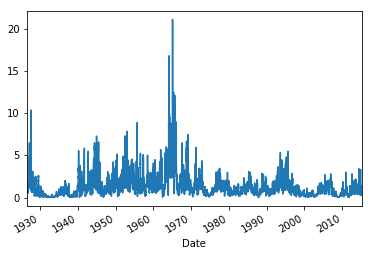

In [6]:
display(volman_strategy(22).tail())
volman_strategy(22).plot()

In [7]:
# b) 
def VMS(ndays_rv, ndays_holding):
    df_mrf = pd.DataFrame({"Mkt": df["Mkt-RF"] + df["RF"],
                           "RF": df["RF"]}, index = df.index)
    df_mrf_com = (df_mrf+1).rolling(ndays_holding).apply(lambda x: x.prod(), raw = True)-1
    df_mrf_com.columns = ['RollComR_Mkt','RollComR_RF']
    df_mrf_com["W"] = volman_strategy(ndays_rv)
    df_mrf_com["RVMS"] = df_mrf_com.W.shift(3)*df_mrf_com.RollComR_Mkt.shift(-ndays_holding)+(1-df_mrf_com.W.shift(3))*df_mrf_com.RollComR_RF.shift(-ndays_holding)
    return(df_mrf_com)

,RollComR_Mkt,RollComR_RF,W,RVMS
Date,,,,
2015-03-25,-0.018118,0.0,0.662368,NaN
2015-03-26,-0.023404,0.0,0.669984,NaN
2015-03-27,-0.020474,0.0,0.662026,NaN
2015-03-30,-0.007435,0.0,0.588452,NaN
2015-03-31,-0.011320,0.0,0.573297,NaN


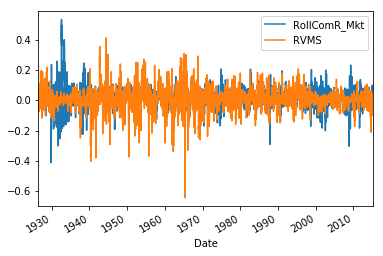

In [8]:
display(VMS(22,22).tail())
(VMS(22,22)[['RollComR_Mkt','RVMS']]).plot()

In [9]:
# d)
def VMS1(ndays_rv, ndays_holding):
    df_mrf = pd.DataFrame({"Mkt": df["Mkt-RF"] + df["RF"],
                            "RF": df["RF"]}, index = df.index)
    df_mrf_com = (df_mrf+1).rolling(ndays_holding).apply(lambda x : x.prod(), raw = True)-1
    df_mrf_com.columns = ['RollComR_Mkt','RollComR_RF']
    df_mrf_com["W"] = volman_strategy(ndays_rv)
    df_mrf_com["RVMS"] = df_mrf_com.W.shift(3)*df_mrf_com.RollComR_Mkt.shift(-ndays_holding)+(1-df_mrf_com.W.shift(3))*df_mrf_com.RollComR_RF.shift(-ndays_holding)
    return(df_mrf_com.iloc[0::ndays_holding,:])

,RollComR_Mkt,RollComR_RF,W,RVMS
Date,,,,
2014-10-30,0.012827,0.0,0.308910,0.011490
2014-12-02,0.035595,0.0,2.284837,-0.040985
2015-01-05,-0.017490,0.0,0.392575,0.010492
2015-02-05,0.023435,0.0,0.365172,-0.000577
2015-03-10,-0.001622,0.0,1.062014,NaN


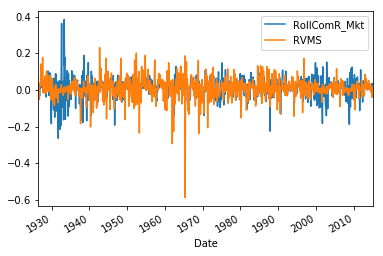

In [10]:
display(VMS1(22,22).tail())
(VMS1(22,22)[['RollComR_Mkt','RVMS']]).plot()

### 3.

a) Ok, now you should have a function that takes two parameters ndays_rv and ndays_holding and returns a data frame that contains date as index (with ndays_holding between dates (in terms of trading dates)), in the columns if you have the returns on the market, on the risk-free rate, and the return of the strategy VMS.


b) Now you should add to the function the following outputs:

   * Annualized mean of market and VMS
   * Annualized mean excess return of market and VMS
   * Annualized stadard deviation of market and VMS
   * Annualized Sharpe ration of market and VMS
   * 1% quantile of market and VMS (i.e, the return realization that is above only 1% of the return realizations. TIP: Use the .quantile method to get this done)
   
TIP:  note that to annualize you have to take into the holding period of the trading stragy. Use the convention that there are 252 days in a year. So if the strategy has 22 days, then the factor is f=252/22

In [11]:
# b)
def VMS_annual(ndays_rv, ndays_holding):
    f = 252/ndays_holding
    VMS_mkt = VMS1(ndays_rv, ndays_holding).iloc[:,[0, 3]]
    mean = VMS_mkt.mean()*f
    meanER = VMS_mkt.subtract(VMS1(ndays_rv, ndays_holding).iloc[:,1], axis=0).mean()*f
    std = VMS_mkt.std()*f**0.5
    SR = (meanER/f)/(VMS_mkt.std())*(f**0.5)
    Quantile = VMS_mkt.quantile(q = 0.01)
    VMS_annual = pd.DataFrame({"Annualized mean": np.array(mean),
                               "Annualized mean excess return": np.array(meanER),
                               "Annualized stadard deviation": np.array(std),
                               "Annualized Sharpe ratio": np.array(SR),
                               "1% quantile": np.array(Quantile)}, index = [["Market", "VMS"]])
    return(VMS_annual)

In [12]:
VMS_annual(22,22)

,Annualized mean,Annualized mean excess return,Annualized stadard deviation,Annualized Sharpe ratio,1% quantile
Market,0.106973,0.074593,0.180327,0.413653,-0.167261
VMS,0.112639,0.080219,0.180448,0.444554,-0.146797


### 4. 

a) Use a for loop to construct a matrix where in the rows you have different realized variance windows, and in the columns different holding periods  and in each entry you have the annualized sharpe ratio.

* You will do that by calling the function that you build and storing the sharpe ratio.

* the goal is to seet how the SR changes as you change the signal formation and the holding period


b) do the same for the market-- the market should have the same SR across columns, but should change with respect to the holding periods





In [13]:
# a) 
def SR_VMS(ndays_rv, ndays_holding):
    SR_VMS = []
    for ndays_rv in range(1, ndays_rv+1):
        for ndays_holding in range(1, ndays_holding+1):
            SR_VMS.append(VMS_annual(ndays_rv, ndays_holding).iloc[1,3])

    SR_VMS_array = np.array(SR_VMS)
    SR_VMS_array.shape = (ndays_rv, ndays_holding)
    SR_VMS_df = pd.DataFrame(data = SR_VMS_array, columns = list(range(1, ndays_holding+1)), index = list(range(1, ndays_rv+1)))
    SR_VMS_df.index.name = "ndays_rv"
    SR_VMS_df.columns.name = "ndays_holding"
    return(SR_VMS_df)

SR_VMS(22,22)

ndays_holding,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
ndays_rv,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.251955,NaN,NaN,NaN
3,0.000987,-0.050845,0.041324,0.088575,-0.055660,0.049398,-0.065165,0.198382,0.142803,0.068045,...,0.112845,-0.101825,0.013301,0.355916,0.073577,0.003840,0.194092,0.026844,-0.131518,0.347581
4,0.324543,0.242667,0.213407,0.197178,0.259501,0.176575,0.109824,0.275858,0.339703,0.346757,...,0.224998,-0.081470,0.217722,0.226900,0.112742,0.148360,0.188724,0.258077,0.066424,0.239134
5,0.467813,0.201376,0.269734,0.309087,0.199037,0.325360,0.325910,0.255485,0.388710,0.341451,...,0.326269,0.290078,0.338770,0.201839,0.320231,0.307335,0.263407,0.227963,0.313075,0.345337
6,0.504610,0.373309,0.379424,0.421126,0.260200,0.394003,0.405034,0.453184,0.408681,0.384744,...,0.373684,0.303376,0.325437,0.288958,0.314795,0.292357,0.202141,0.283686,0.342117,0.439502
7,0.571393,0.446331,0.433094,0.466768,0.345230,0.387922,0.424179,0.413770,0.358006,0.387712,...,0.456064,0.302122,0.309521,0.302389,0.333092,0.235042,0.241506,0.331389,0.406784,0.440128
8,0.530081,0.408041,0.439713,0.424680,0.364899,0.379641,0.403985,0.409215,0.401716,0.394695,...,0.376605,0.336863,0.338299,0.342252,0.349855,0.301917,0.235463,0.383722,0.386094,0.408157
9,0.516323,0.445521,0.447426,0.432280,0.373533,0.384174,0.374058,0.407745,0.403109,0.381738,...,0.366355,0.308780,0.341148,0.346074,0.316308,0.315543,0.265411,0.376003,0.359704,0.320435


In [14]:
# b) 
def SR_MKT(ndays_rv, ndays_holding):
    SR_MKT = []
    for ndays_rv in range(1, ndays_rv+1):
        for ndays_holding in range(1, ndays_holding+1):
            SR_MKT.append(VMS_annual(ndays_rv, ndays_holding).iloc[0,3])

    SR_MKT_array = np.array(SR_MKT)
    SR_MKT_array.shape = (ndays_rv, ndays_holding)
    SR_MKT_df = pd.DataFrame(data = SR_MKT_array, columns = list(range(1, ndays_holding+1)), index = list(range(1, ndays_rv+1)))
    SR_MKT_df.index.name = "ndays_rv"
    SR_MKT_df.columns.name = "ndays_holding"
    return(SR_MKT_df)

SR_MKT(22,22)

ndays_holding,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
ndays_rv,,,,,,,,,,,,,,,,,,,,,
1,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
2,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
3,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
4,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
5,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
6,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
7,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
8,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
9,0.426997,0.418664,0.422558,0.417484,0.424793,0.417511,0.411247,0.417451,0.421541,0.418171,...,0.410017,0.417186,0.412336,0.415282,0.411167,0.413049,0.414062,0.407454,0.416085,0.413653
